In [1]:
# Get all imports
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import torch
# Create a device variable which will be used to shift model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### A function to generate spiral data

In [2]:
def gen_data(num_samples, class_sep=3, noise=0.2):
    # Sample from a uniform random distribution
    samples = np.random.uniform(0, 20, num_samples)
    # Make the samples highly positive and shift them. These samples will become class 0
    samples_class0 = 2 * samples + class_sep
    # The X axis is the cos part and y axis is the sin part
    samples_class0 = np.array([np.cos(samples) * samples_class0, np.sin(samples) * samples_class0]).T
    # Add some noise to the data
    samples_class0+= np.random.normal(0, noise, (num_samples, 2))
    # Make the samples highly negative and shift them. These samples will become class 1
    samples_class1 = -2 * samples - class_sep
    # The X axis is the cos part and y axis is the sin part
    samples_class1 = np.array([np.cos(samples) * samples_class1, np.sin(samples) * samples_class1]).T
    # Add some noise to the data
    samples_class1+= np.random.normal(0, noise, (num_samples, 2))
    # Concatenate samples from both class
    X = np.append(samples_class0, samples_class1, axis=0)
    # Generate corresponding class labels
    Y = np.append(np.zeros(num_samples, dtype=int), np.ones(num_samples, dtype=int), axis=0)
    return X, Y

### Generate Data and Visualize

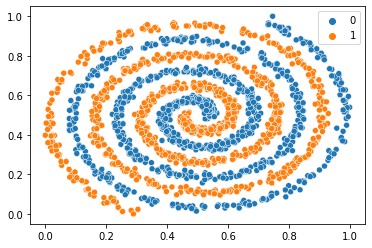

In [3]:
num_samples = 1000
X, Y = gen_data(num_samples, 3, 0.8)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y)
plt.show()

### Create a single hidden layer feed-forward neural network a.k.a. Multi-layer perceptron

In [4]:
from torch.nn import functional as F

class FFN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 512)
        self.layer2 = torch.nn.Linear(512, 128)
        self.layer3 = torch.nn.Linear(128, 2)
    
    def forward(self, x):
        # Change the activation function and see what effect we get
        # x = F.tanh(self.layer1(x))
        # x = F.tanh(self.layer2(x))
        # x = self.layer3(x)
        x = torch.nn.Tanh()(self.layer1(x))
        x = torch.nn.Tanh()(self.layer2(x))
        x = self.layer3(x)
        return x

### Generate a pytorch dataloader for our training data

In [5]:
# First create a pytorch dataset from the numpy data
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
# Create a dataloader object which will create batches of data
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)

### Now perform training of the model

In [6]:
# Set the number of epochs to be used
epochs = 200
# Create the model
model = FFN().to(device)
# Define Loss
loss_function = torch.nn.CrossEntropyLoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# These two lists will be used to store average loss and accuracy for each epoch
total_loss, acc = list(), list()
# Now write out the training procedure
for epoch in range(epochs):
    print("\n\nEpoch:", epoch+1)
    # Each batch produces a loss, predictions and target
    batch_loss, batch_preds, batch_target = 0, list(), list()
    # For each batch, train the model
    for x, y in tqdm(dataloader_train, total=len(dataloader_train)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        # Remove all previous gradients
        optimizer.zero_grad()
        # Get predictions by performing a forward pass
        preds = model.forward(x.float())
        # Calculate error
        loss = loss_function(preds, y.to(torch.int64))
        # Calculate all the gradients for each layer
        loss.backward()
        # Finall, update the weights
        optimizer.step()
        # Save the loss
        batch_loss+= loss.item()
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.cpu().detach().numpy())
    # Calculate average loss
    total_loss.append(batch_loss/len(dataloader_train))
    # Calculate accuracy for this epoch
    acc.append(accuracy_score(batch_target, batch_preds))
    print("Loss:", total_loss[-1], "\tAcc:", acc[-1])



Epoch: 1


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.7234138174662514 	Acc: 0.539


Epoch: 2


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6926352334400964 	Acc: 0.538


Epoch: 3


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6910704894671365 	Acc: 0.5295


Epoch: 4


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6942103192919776 	Acc: 0.5325


Epoch: 5


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6897722558369712 	Acc: 0.52


Epoch: 6


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6909834203265962 	Acc: 0.517


Epoch: 7


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6873456116706606 	Acc: 0.538


Epoch: 8


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.68282674702387 	Acc: 0.534


Epoch: 9


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6845144184808882 	Acc: 0.526


Epoch: 10


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6746446717353094 	Acc: 0.538


Epoch: 11


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6747547738135807 	Acc: 0.5455


Epoch: 12


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.678134420561412 	Acc: 0.54


Epoch: 13


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6769047805241176 	Acc: 0.5515


Epoch: 14


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.672925835564023 	Acc: 0.538


Epoch: 15


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6663438393956139 	Acc: 0.555


Epoch: 16


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6758899395428006 	Acc: 0.5215


Epoch: 17


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6781208988219972 	Acc: 0.544


Epoch: 18


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6620596524268861 	Acc: 0.5545


Epoch: 19


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6755905387893556 	Acc: 0.5415


Epoch: 20


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6764838638759795 	Acc: 0.5435


Epoch: 21


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6714898234321958 	Acc: 0.5555


Epoch: 22


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6671575941736736 	Acc: 0.5555


Epoch: 23


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6599198106735472 	Acc: 0.563


Epoch: 24


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6560175958133879 	Acc: 0.5555


Epoch: 25


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6447419041679019 	Acc: 0.5645


Epoch: 26


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6520690407071795 	Acc: 0.563


Epoch: 27


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6395531221041604 	Acc: 0.571


Epoch: 28


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6548235217730204 	Acc: 0.554


Epoch: 29


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6327731770182413 	Acc: 0.585


Epoch: 30


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6333511878573705 	Acc: 0.602


Epoch: 31


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6316758403702388 	Acc: 0.6


Epoch: 32


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6322506590495034 	Acc: 0.606


Epoch: 33


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6302698879014879 	Acc: 0.602


Epoch: 34


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6296058505300491 	Acc: 0.606


Epoch: 35


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.606582107998076 	Acc: 0.6465


Epoch: 36


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5971830477790226 	Acc: 0.659


Epoch: 37


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.6051685318114266 	Acc: 0.639


Epoch: 38


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5914041409416805 	Acc: 0.6645


Epoch: 39


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5924490841608199 	Acc: 0.668


Epoch: 40


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5853218332169547 	Acc: 0.6625


Epoch: 41


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5789079869550372 	Acc: 0.6705


Epoch: 42


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5761605624168639 	Acc: 0.6895


Epoch: 43


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5671264997550419 	Acc: 0.6885


Epoch: 44


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5865911775165134 	Acc: 0.6825


Epoch: 45


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5591247341935597 	Acc: 0.6945


Epoch: 46


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.558602000512774 	Acc: 0.693


Epoch: 47


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5416204801627568 	Acc: 0.7195


Epoch: 48


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5542670824224987 	Acc: 0.696


Epoch: 49


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5279039390503414 	Acc: 0.7255


Epoch: 50


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5246370065779913 	Acc: 0.73


Epoch: 51


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5334448823853145 	Acc: 0.721


Epoch: 52


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5313862093857357 	Acc: 0.7215


Epoch: 53


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5153997876341381 	Acc: 0.73


Epoch: 54


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.5219137167173719 	Acc: 0.733


Epoch: 55


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.49311646204146126 	Acc: 0.7705


Epoch: 56


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.49606264536342926 	Acc: 0.767


Epoch: 57


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.4921917432830447 	Acc: 0.767


Epoch: 58


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.4732094766601684 	Acc: 0.788


Epoch: 59


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.47715355384917485 	Acc: 0.773


Epoch: 60


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.45704056913890534 	Acc: 0.7955


Epoch: 61


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.45126470639592126 	Acc: 0.808


Epoch: 62


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.44546272404610165 	Acc: 0.8045


Epoch: 63


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.4416727726421659 	Acc: 0.806


Epoch: 64


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.43646551077328033 	Acc: 0.8015


Epoch: 65


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.4305801732199533 	Acc: 0.819


Epoch: 66


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.4077534566796015 	Acc: 0.834


Epoch: 67


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.40623829431003994 	Acc: 0.8315


Epoch: 68


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.41181122026746236 	Acc: 0.8265


Epoch: 69


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.420100427336163 	Acc: 0.822


Epoch: 70


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.39972851957593647 	Acc: 0.842


Epoch: 71


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.4036008053355747 	Acc: 0.8205


Epoch: 72


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3703728393902854 	Acc: 0.858


Epoch: 73


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3650026477518536 	Acc: 0.865


Epoch: 74


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3562318427222116 	Acc: 0.87


Epoch: 75


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3519548750112927 	Acc: 0.8755


Epoch: 76


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.342109205230834 	Acc: 0.873


Epoch: 77


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3369393116898007 	Acc: 0.8795


Epoch: 78


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.33028641248506213 	Acc: 0.8775


Epoch: 79


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.32785254906094263 	Acc: 0.885


Epoch: 80


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.32626449021082077 	Acc: 0.8855


Epoch: 81


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3088443787798049 	Acc: 0.896


Epoch: 82


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3082029076795729 	Acc: 0.8915


Epoch: 83


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.29577256076865727 	Acc: 0.8905


Epoch: 84


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.29511006318387534 	Acc: 0.907


Epoch: 85


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2833315720633855 	Acc: 0.9095


Epoch: 86


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.3256124447262476 	Acc: 0.888


Epoch: 87


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2688061273287213 	Acc: 0.9125


Epoch: 88


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2807687880500915 	Acc: 0.911


Epoch: 89


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2760635782328863 	Acc: 0.9095


Epoch: 90


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.27016546991136337 	Acc: 0.916


Epoch: 91


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.25818209243672235 	Acc: 0.9165


Epoch: 92


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.24740948610835606 	Acc: 0.9255


Epoch: 93


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.26273376932219855 	Acc: 0.9145


Epoch: 94


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.23597196785230484 	Acc: 0.92


Epoch: 95


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.24522724085383946 	Acc: 0.921


Epoch: 96


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.24563898122499858 	Acc: 0.922


Epoch: 97


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.23734154871531896 	Acc: 0.923


Epoch: 98


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.23499880518232072 	Acc: 0.922


Epoch: 99


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2511276203015494 	Acc: 0.9145


Epoch: 100


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.23645522268045516 	Acc: 0.924


Epoch: 101


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.22355955034967454 	Acc: 0.925


Epoch: 102


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2196460957565005 	Acc: 0.9355


Epoch: 103


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2352987780930504 	Acc: 0.9255


Epoch: 104


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2195551482931016 	Acc: 0.9335


Epoch: 105


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.21071371779082312 	Acc: 0.9345


Epoch: 106


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.22440888827282285 	Acc: 0.921


Epoch: 107


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.23326673086673494 	Acc: 0.9255


Epoch: 108


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.20718347080170163 	Acc: 0.9385


Epoch: 109


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.20593894012863673 	Acc: 0.937


Epoch: 110


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1921584317608485 	Acc: 0.9405


Epoch: 111


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.20996971132736358 	Acc: 0.93


Epoch: 112


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19587678367656375 	Acc: 0.942


Epoch: 113


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.20307526217093544 	Acc: 0.9365


Epoch: 114


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.20138486167268146 	Acc: 0.94


Epoch: 115


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.216164235794355 	Acc: 0.927


Epoch: 116


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19929694254246968 	Acc: 0.9265


Epoch: 117


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19336298746722086 	Acc: 0.939


Epoch: 118


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1921135423675416 	Acc: 0.9385


Epoch: 119


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1923210070956321 	Acc: 0.944


Epoch: 120


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19035396795897258 	Acc: 0.936


Epoch: 121


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.21598288133030846 	Acc: 0.921


Epoch: 122


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.2125895515320793 	Acc: 0.923


Epoch: 123


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.18195552733682452 	Acc: 0.9455


Epoch: 124


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.18366892588517023 	Acc: 0.943


Epoch: 125


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19082949215930606 	Acc: 0.938


Epoch: 126


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.18600914982103167 	Acc: 0.9395


Epoch: 127


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17921938321420125 	Acc: 0.945


Epoch: 128


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19074730433168866 	Acc: 0.9355


Epoch: 129


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17555774227967338 	Acc: 0.9455


Epoch: 130


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16821276479297215 	Acc: 0.948


Epoch: 131


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17812278914073157 	Acc: 0.9395


Epoch: 132


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.19802757033279964 	Acc: 0.93


Epoch: 133


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16482073364276734 	Acc: 0.946


Epoch: 134


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1702873615754975 	Acc: 0.9435


Epoch: 135


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17398330817619959 	Acc: 0.9455


Epoch: 136


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.20770979672670364 	Acc: 0.926


Epoch: 137


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.18714811144367097 	Acc: 0.939


Epoch: 138


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17850799284993657 	Acc: 0.944


Epoch: 139


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1894155443897323 	Acc: 0.928


Epoch: 140


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1731983825327858 	Acc: 0.9395


Epoch: 141


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15771101864557419 	Acc: 0.954


Epoch: 142


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1926304106674497 	Acc: 0.935


Epoch: 143


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1767914972844578 	Acc: 0.947


Epoch: 144


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1704601546128591 	Acc: 0.9505


Epoch: 145


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17425771767184847 	Acc: 0.939


Epoch: 146


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14662583580329305 	Acc: 0.96


Epoch: 147


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16369834897064028 	Acc: 0.953


Epoch: 148


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15318641669693447 	Acc: 0.9555


Epoch: 149


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16613652799574155 	Acc: 0.9535


Epoch: 150


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15228186535929877 	Acc: 0.959


Epoch: 151


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1662042098385947 	Acc: 0.9485


Epoch: 152


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16289827765689957 	Acc: 0.947


Epoch: 153


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1686730148300292 	Acc: 0.942


Epoch: 154


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15502260181875455 	Acc: 0.954


Epoch: 155


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17731777915642374 	Acc: 0.9425


Epoch: 156


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16910730479728608 	Acc: 0.942


Epoch: 157


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.17246359078184006 	Acc: 0.9365


Epoch: 158


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15980161549079985 	Acc: 0.947


Epoch: 159


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14598161880932156 	Acc: 0.9585


Epoch: 160


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14681078801079403 	Acc: 0.9535


Epoch: 161


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13439637954745973 	Acc: 0.953


Epoch: 162


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.139670802546399 	Acc: 0.9585


Epoch: 163


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13432310261423624 	Acc: 0.958


Epoch: 164


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13264614379122144 	Acc: 0.9585


Epoch: 165


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.136339608875532 	Acc: 0.958


Epoch: 166


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14738694140835415 	Acc: 0.9515


Epoch: 167


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14594457753830486 	Acc: 0.951


Epoch: 168


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.147650476899885 	Acc: 0.9495


Epoch: 169


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1453941554895469 	Acc: 0.9565


Epoch: 170


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1765458621676006 	Acc: 0.9365


Epoch: 171


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15746136559616952 	Acc: 0.9465


Epoch: 172


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1648584928895746 	Acc: 0.939


Epoch: 173


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15739660922970092 	Acc: 0.95


Epoch: 174


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14116173846617577 	Acc: 0.961


Epoch: 175


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1405118985308541 	Acc: 0.947


Epoch: 176


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13096816222819072 	Acc: 0.961


Epoch: 177


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13360113751084085 	Acc: 0.9605


Epoch: 178


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13045249326479813 	Acc: 0.9585


Epoch: 179


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13206896449010525 	Acc: 0.96


Epoch: 180


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.129085351964311 	Acc: 0.958


Epoch: 181


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14415419361894094 	Acc: 0.9505


Epoch: 182


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15268923105701568 	Acc: 0.943


Epoch: 183


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.12066985294222832 	Acc: 0.961


Epoch: 184


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.12631684795968115 	Acc: 0.9575


Epoch: 185


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.14465858680861338 	Acc: 0.952


Epoch: 186


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.15392343132268815 	Acc: 0.9455


Epoch: 187


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.12656721910313953 	Acc: 0.958


Epoch: 188


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.12599772625854092 	Acc: 0.957


Epoch: 189


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1243151379010034 	Acc: 0.957


Epoch: 190


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.11728367363176649 	Acc: 0.964


Epoch: 191


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.13432429127749942 	Acc: 0.952


Epoch: 192


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1508581152865811 	Acc: 0.952


Epoch: 193


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.16446574688667343 	Acc: 0.951


Epoch: 194


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1546609088896759 	Acc: 0.947


Epoch: 195


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1333873159000798 	Acc: 0.9585


Epoch: 196


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.11976843800336595 	Acc: 0.961


Epoch: 197


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1319869655583586 	Acc: 0.96


Epoch: 198


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1195720923207109 	Acc: 0.963


Epoch: 199


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.10635770993336799 	Acc: 0.967


Epoch: 200


  0%|          | 0/63 [00:00<?, ?it/s]

Loss: 0.1161837802519874 	Acc: 0.9675


### We will now visualize the decision boundary of model

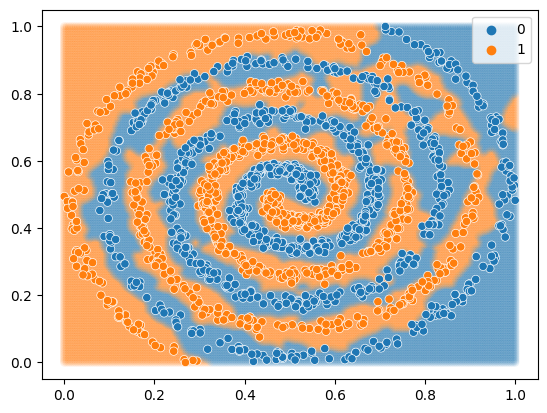

In [7]:
# Generate a grid of evenly spaced points
x1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 200)
x2 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 200)
X1, X2 = np.meshgrid(x1, x2)
X_test = np.array((X1.ravel(), X2.ravel())).T

# Create a pytorch dataset from the numpy data
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test))
# Create a dataloader object which will create batches of data
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=512, shuffle=False)

# We will now ask the model to predict each sample in the grid.
# This gives us a nice idea of what the model has learned
total_preds = list()
for x in dataloader_test:
    x = x[0].to(device)
    preds = model.forward(x.float())
    total_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))

# Let's visualize the predictions
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=total_preds, alpha=0.1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y, legend=False)
plt.show()

### Is the model really generalizing? Let's answer it by visualizing the decision boundary again

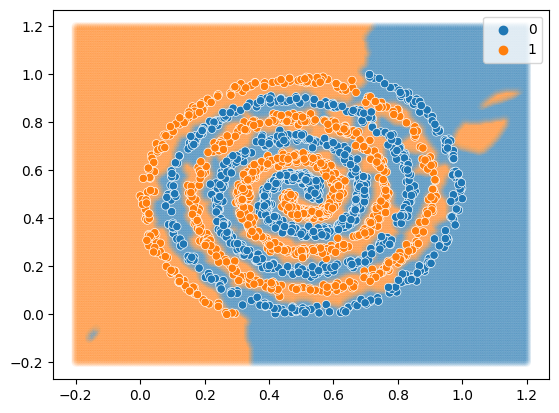

In [8]:
# Generate a grid of evenly spaced points
x1 = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 200)
x2 = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 200)
X1, X2 = np.meshgrid(x1, x2)
X_test = np.array((X1.ravel(), X2.ravel())).T

# Create a pytorch dataset from the numpy data
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test))
# Create a dataloader object which will create batches of data
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=512, shuffle=False)

# We will now ask the model to predict each sample in the grid.
# This gives us a nice idea of what the model has learned
total_preds = list()
for x in dataloader_test:
    x = x[0].to(device)
    preds = model.forward(x.float())
    total_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))

# Let's visualize the predictions
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=total_preds, alpha=0.1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=Y, legend=False)
plt.show()